In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image
# from sklearn.model_selection import train_test_split
from verstack.stratified_continuous_split import scsplit

c:\Users\timcy\Anaconda3\envs\ml\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
scan_1 = Image.open("C:/Users/timcy/Documents/Code/Personal/U-Net/data/scans/bjorke_1.png")
rs = 42
np.random.seed(rs)

In [3]:
import os

# Directory containing the scans
scans_dir = "C:/Users/timcy/Documents/Code/Personal/U-Net/data/scans/"
masks_dir = "C:/Users/timcy/Documents/Code/Personal/U-Net/data/masks/"

# List to store the paths of all png files
scans = []
masks = []
shapes = []

# Iterate over all files in the directory
for filename in tqdm(os.listdir(scans_dir)):
    scan = np.array(Image.open(os.path.join(scans_dir, filename)).convert('L'))
    mask = np.array(Image.open(os.path.join(masks_dir, filename)).convert('L'))
    scans.append(scan)
    masks.append(mask)
    shape = scan.shape
    shapes.append(shape)

100%|██████████| 2729/2729 [00:43<00:00, 62.97it/s]


In [4]:
filename

'Morozov_study_0304_36.png'

In [5]:
scans[0].shape

(512, 512)

In [6]:
print(len(scans))
print(len(masks))

2729
2729


In [7]:
np.mean(masks)

np.float64(3.8502800418326775)

In [8]:
mask_coverages = []
zero_masks = []

for mask in tqdm(masks):
    # Calculate the mask coverage as a percentage
    mask_coverage = np.mean(mask) / 2.55
    mask_coverages.append(mask_coverage)
    if mask_coverage == 0:
        zero_masks.append(mask)

100%|██████████| 2729/2729 [00:00<00:00, 5932.64it/s]


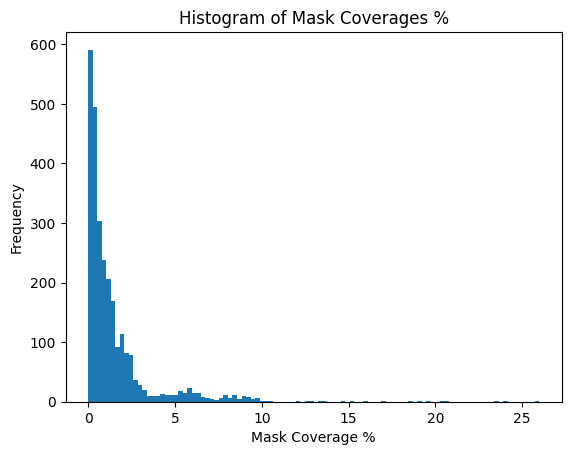

In [9]:
import matplotlib.pyplot as plt

plt.hist(mask_coverages, bins=100)
plt.title('Histogram of Mask Coverages %')
plt.xlabel('Mask Coverage %')
plt.ylabel('Frequency')
plt.show()

In [10]:
print(len(mask_coverages))
print(len(zero_masks))

2729
1


In [11]:
# index = 1000

blend_images = []

for index in tqdm(range(len(scans))):
    mask = masks[index].copy()
    scan = scans[index].copy()
    red_mask = np.stack((mask, np.zeros_like(mask), np.zeros_like(mask)), axis=2)
    scan = np.stack((scan, scan, scan), axis=2)

    scan = Image.fromarray(scan)
    mask = Image.fromarray(red_mask)
    blend_image = Image.blend(scan, mask, 0.5)

    blend_images.append(np.array(blend_image))

100%|██████████| 2729/2729 [00:12<00:00, 219.50it/s]


In [12]:
df = pd.DataFrame({"scan": scans, "mask": masks, "blend_image": blend_images, "mask_coverage": mask_coverages, "shape": shapes})

In [13]:
df.describe()

,mask_coverage
count,2729.000000
mean,1.509914
std,2.337186
min,0.000000
25%,0.302124
50%,0.755692
75%,1.667404
max,25.975007


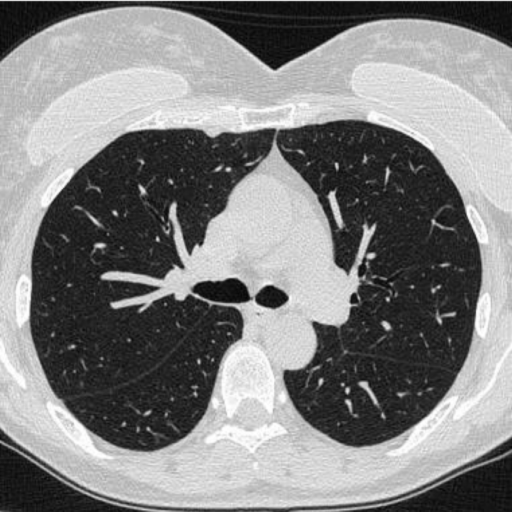

In [14]:
Image.fromarray(list(df.loc[df["mask_coverage"] < 0.00001, "scan"])[0])

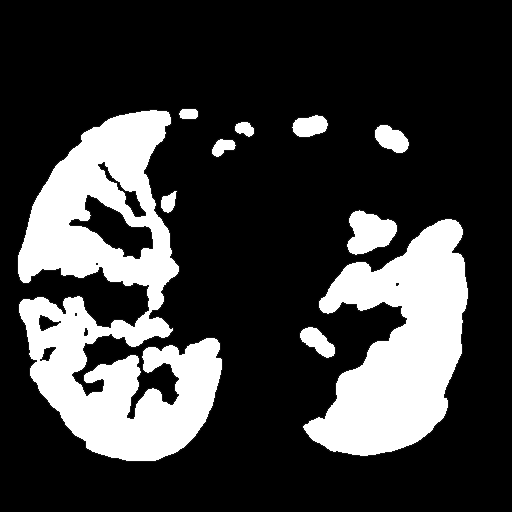

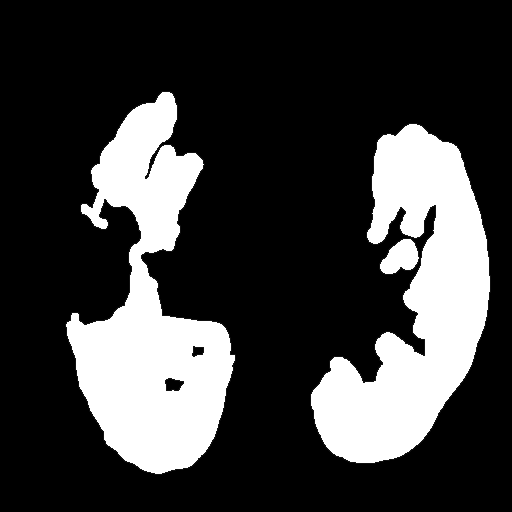

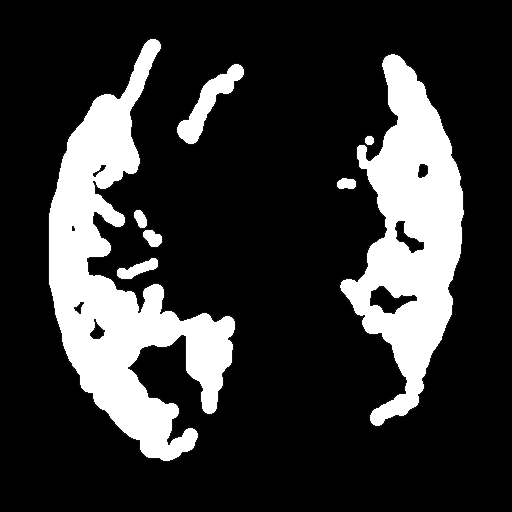

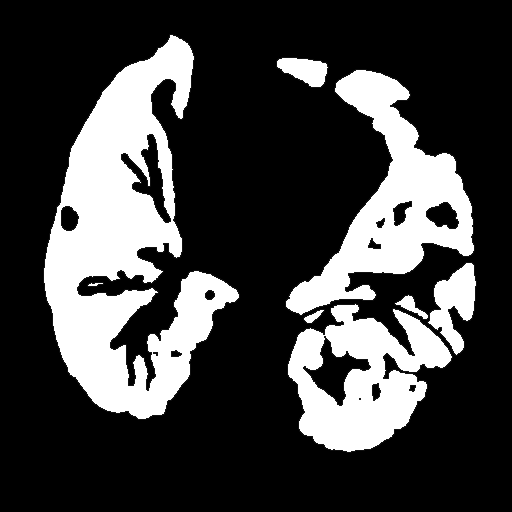

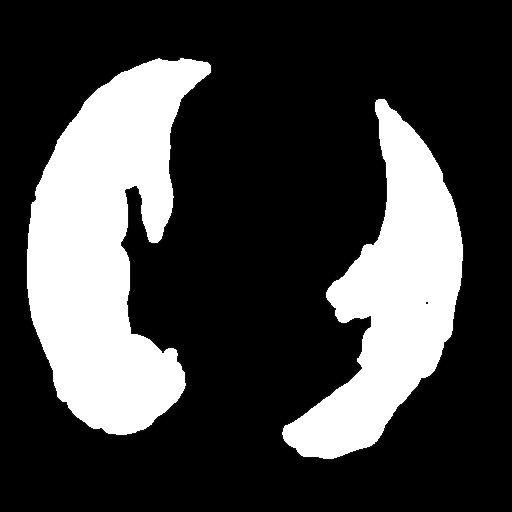

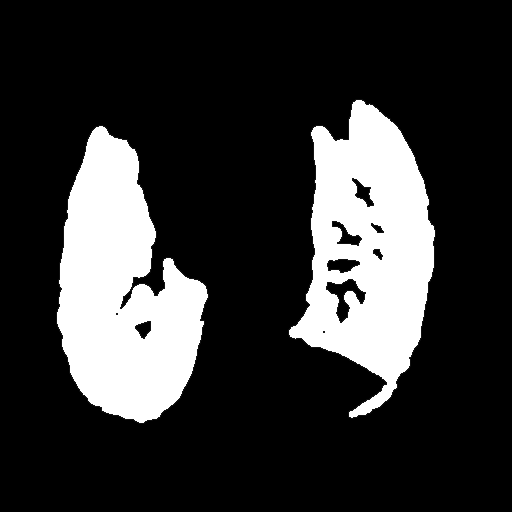

In [15]:
for img in list(df.loc[df["mask_coverage"] > 20, "mask"]):
    display(Image.fromarray(img))

In [16]:
df.iloc[0]

scan             [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...
mask             [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
blend_image      [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...
mask_coverage                                            13.711786
shape                                                   (512, 512)
Name: 0, dtype: object

# Split

In [17]:
len(df)

2729

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2729 entries, 0 to 2728
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   scan           2729 non-null   object 
 1   mask           2729 non-null   object 
 2   blend_image    2729 non-null   object 
 3   mask_coverage  2729 non-null   float64
 4   shape          2729 non-null   object 
dtypes: float64(1), object(4)
memory usage: 106.7+ KB


In [19]:
train_df, test_df = scsplit(
    df, 
    stratify=df["mask_coverage"],
    test_size=0.25,
    train_size=0.75,
    random_state=rs, 
)
val_df, test_df = scsplit(
    test_df, 
    stratify=test_df["mask_coverage"],
    test_size=0.5,
    train_size=0.5,
    random_state=rs, 
)

In [20]:
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)
print(len(train_df) + len(val_df) + len(test_df))
print(len(df))

(2046, 5)
(341, 5)
(342, 5)
2729
2729


In [21]:
print(train_df["mask_coverage"].mean())
print(val_df["mask_coverage"].mean())
print(test_df["mask_coverage"].mean())

1.526768934280477
1.5003735477205566
1.4185905915828847


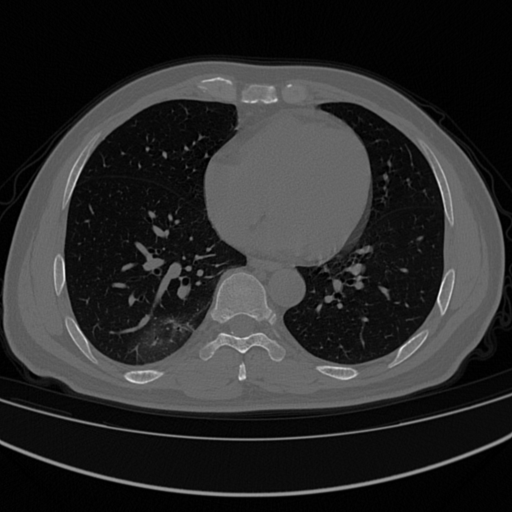

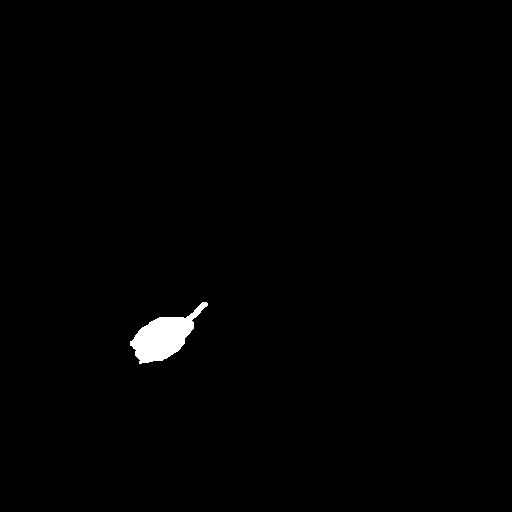

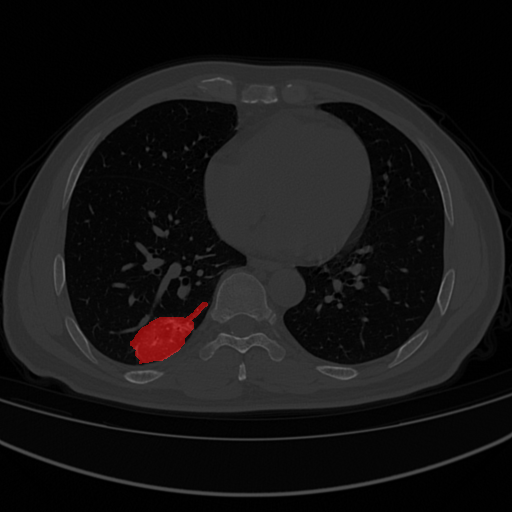

In [22]:
display(Image.fromarray(train_df.iloc[0]["scan"]))
display(Image.fromarray(train_df.iloc[0]["mask"]))
display(Image.fromarray(train_df.iloc[0]["blend_image"]))

In [23]:
df.to_csv("../data/df.csv")

In [48]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
from torch.utils.data import DataLoader
from torch.utils.data import Subset
from torchvision import datasets, transforms
import torchvision.transforms as transforms

In [32]:
image = Image.open(os.path.join(scans_dir, filename)).convert('L')
mask = Image.open(os.path.join(masks_dir, filename)).convert('L')

In [37]:
transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Resize((128, 128)),
])
image_tensor = transform(image)
mask_tensor = transform(mask)
print(image_tensor.shape)
print(mask_tensor.shape)

torch.Size([1, 512, 512])
torch.Size([1, 512, 512])


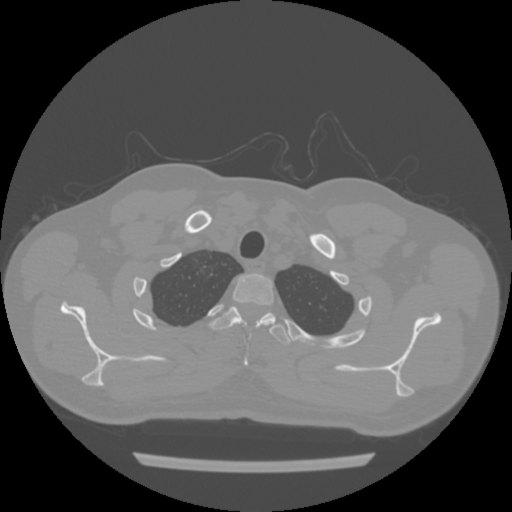

In [47]:
transforms.ToPILImage()(image_tensor)

In [68]:
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(UNet, self).__init__()

        self.enc1 = self.conv_block(in_channels, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)

        self.dec1 = self.conv_block(512, 256)
        self.dec2 = self.conv_block(256, 128)
        self.dec3 = self.conv_block(128, 64)
        self.dec4 = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        x1 = self.enc1(x)
        x2 = self.enc2(self.pool(x1))
        x3 = self.enc3(self.pool(x2))
        x4 = self.enc4(self.pool(x3))

        x = self.upconv3(x4)
        x = torch.cat([x, x3], dim=2)
        x = self.dec1(x)

        x = self.upconv3(x)
        x = torch.cat([x, x2], dim=2)
        x = self.dec2(x)

        x = self.upconv3(x)
        x = torch.cat([x, x1], dim=2)
        x = self.dec3(x)

        x = self.dec4(x)
        return x
        
    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

In [69]:
model = UNet(in_channels=1, out_channels=1)
model.eval()

with torch.no_grad():
    prediction = model(image_tensor).squeeze(0)

plt.imshow(prediction)
# plt.show()

RuntimeError: Given groups=1, weight of size [256, 512, 3, 3], expected input[1, 256, 128, 256] to have 512 channels, but got 256 channels instead

In [ ]:
    # model.eval()

    # with torch.no_grad():
    #     prediction = model(image_tensor).squeeze(0)

    # prediction = prediction.cpu().numpy()
    # prediction_image = Image.fromarray(prediction, mode='L')
    # prediction_image.show()